In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from IPython.display import Image
from qutip import *
from math import sqrt
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema

In [2]:
from qutip.ipynbtools import plot_animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.animation as animation
from IPython.display import HTML

In [23]:
#
# System constants
#
# https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.105.173601?casa_token=ZeV560uY7gMAAAAA%3AFVbNRofeaxpIhNUnGl8zt3SMTmx20CgngNv3gdXy9uHARf2OrcENzKAsLoVHqnZ3zZm5WqjGmbITig 
# https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.105.100505?casa_token=kO3ld98M9VsAAAAA%3Ad3hMI-n-0txuQ-Jp8HbD3lEe0YXSHpdwX35XU49pUEHSoF6SBciFzyCnIcE-6M4ukZAiIh3WeET2lw
# Schuster Thesis
GHz = 10**9 #Hz
wc = 5.5 * GHz * 2 * np.pi # cavity frequency (5.5 GHz Schuster)
wa = wc + 0*GHz*2*np.pi # qubit frequency, wa + 0.35 GHz Schuster, 0.002 good for rabi
g = 0.017 * GHz * 2 * np.pi # coupling strength (orignally 0.017 GHz)
N = 20       # num cavity fock states
use_rwa = True       # rotating wave approx.? Only use when wa-wc small
n_th_a = 0  # number of thermal photons entering the cavity, 200 mK
n = 0  # starting fock state of the system


# the list of 'times' to evolve over
tlist = np.linspace(0, 50/GHz, 101) # tlist = np.linspace(0,25,101) pedagogical value

# cavity dissapation rate
# kappa = 0.0005  * GHz * 2 * np.pi 
kappa = 0.005  * GHz * 2 * np.pi 

# qubit dissapation rate
# gamma = 0.002 * 2 * np.pi * kappa # (g/(wa-wc))^2k 
gamma = 0.002 * 2 * np.pi * kappa

In [24]:
# Calculate expected Rabi Oscillation Frequency
# https://en.wikipedia.org/wiki/Vacuum_Rabi_oscillation
# https://www.rp-photonics.com/rabi_oscillations.html#:~:text=The%20angular%20frequency%20of%20the,amplitude%20divided%20by%20Planck's%20constant.

r = sqrt(4*(g**2)*(n + 1) + (wa-wc)**2)/GHz # rabi frequency in GHz
print(f"Expected Rabi Oscillation Frequency {r} GHz")
print(f"Expected Rabi Oscillation Period {1/r} ns")

#first intersection of the curves at resonance (wa=wc)
if wa == wc:
    t_max = np.pi/(r)
    print(f"The first intersection when wa=wc is at {t_max} ns")
            

Expected Rabi Oscillation Frequency 0.2136283004441059 GHz
Expected Rabi Oscillation Period 4.6810277379969225 ns
The first intersection when wa=wc is at 14.705882352941178 ns


In [7]:
# for beats to be accurate, the frequencis must <= 1 kHz

# Calculate Carrier and Modulating Frequencies (If the wa-wc is the right size; there is an imaginary component)
fc = abs(wa/(2*np.pi)-wc/(2*np.pi))/(GHz)
fm = abs(wa/(2*np.pi)+wc/(2*np.pi))/(GHz)
# fc = abs(wa-wc)/(2*GHz)
# fm = abs(wa+wc)/(2*GHz)

print(f"Carrier frequency: {fc} GHz, Modulating Frequency: {fm} GHz")
print(f"Carrier period: {1/fc} ns, Modulating Period: {1/fm} ns")

Carrier frequency: 0.0 GHz, Modulating Frequency: 11.0 GHz


ZeroDivisionError: float division by zero

In [25]:
#
# Operators, Hamiltonion
#

# annhiliation and spin operator
a  = tensor(destroy(N), qeye(2))  # this stuff is default fock basis
sm = tensor(qeye(N), destroy(2))


#number of photons in cavity, and in qubit (operators)
nc = a.dag() * a
na = sm.dag() * sm 

#Hamiltonian: Jaynes-Cumming
if use_rwa:
    H = wc * nc + wa * na + g * (a.dag() * sm + a * sm.dag())
else:
    H = wc * nc + wa * na + g * (a.dag() + a) * (sm + sm.dag())
    

In [26]:
#
# Initial state
#

evals, ekets = H.eigenstates()
psi_gnd = ket2dm(ekets[0]) #ground state density matrix
psi_e1 = ket2dm(ekets[1])
psi_gnd
# psi_e1

Quantum object: dims = [[20, 2], [20, 2]], shape = (40, 40), type = oper, isherm = True
Qobj data =
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

In [27]:
#
# Trying something with time evolution
#

# put qubit in excited state to start 
psi0 = tensor(basis(N,0), basis(2,1))

# create dissapation operators list (not sure why the list is needed)
collapse_ops = []

# assume cavity at 0K, cavity relaxation
rate = kappa
if rate > 0:
    collapse_ops.append(sqrt(rate)*a)

rate = kappa * n_th_a
if rate > 0:
    collapse_ops.append(sqrt(rate)*a.dag())
    
# qubit relaxation
rate = gamma
if rate > 0:
    collapse_ops.append(sqrt(rate) * sm)

# make the system evolve
output = mesolve(H, psi0, tlist, collapse_ops, [nc, na])

In [31]:
def time_for_val(times, output, outputs):
    """
    returns: the time at which a desired output occurs
    params: times - list of x values
        output - the output of interest to match x value to
        outputs - the total list of outputs
    """
    val_range = 0.005 # the range to consider values within to get result
    # first find the desired output in the outputs list
    out_idxL = np.where(abs(outputs-output) <= val_range)
    timesL = times[out_idxL]
    
    #trim so that it only includes time values that are notably different
    timesL = np.array(timesL)
    timesL = np.around(timesL, 9) # since we are in the GHz range we want the same order of accuracy
    timesL = np.unique(timesL)
    return timesL

Rabi Frequency from fitting: 0.2130649706980492GHz


Text(0.5, 1.0, 'Vacuum Rabi oscillations')

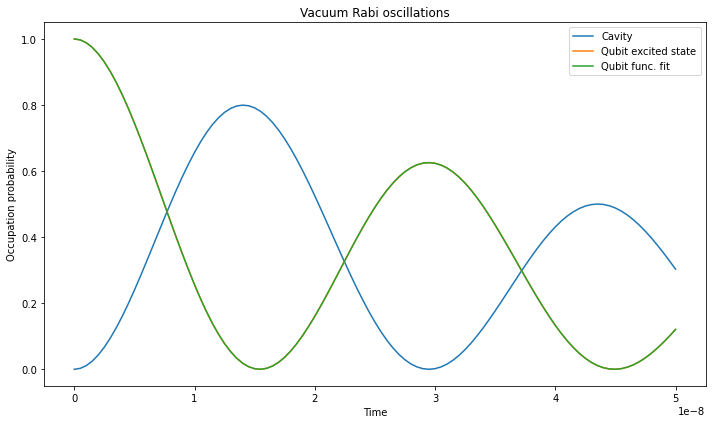

In [38]:
#
# Graph the time evolution
#

n_c = output.expect[0] # expectation value for the number of photons in the cavity 
n_a = output.expect[1] # expectation value for the number of photons in the qubit

# initial fitting guesses
amp1 = (max(n_a) - min(n_a))/2
freq1 = 1/((time_for_val(tlist,0,n_a)[1] - time_for_val(tlist,0,n_a)[0])) #Hz
shift1 = amp1 + min(n_a) 
phase1 = time_for_val(tlist,shift1,n_a)[0]
l_max = argrelextrema(n_a, np.greater)[0] # get np.array in a tuple of the local maxima of the qubit
damp1 = -(np.log(n_a[l_max[0]]))/(tlist[l_max[0]])

# The fit function
# Only use if you expect sinusoidal behavior
def test(x, a, b,c, d,e):
    return a*np.exp(-e*x)*(np.sin(b*x + c))**2 + d

param, param_cov = curve_fit(test, tlist, n_a, maxfev=500000, p0=[amp1, freq1, phase1, shift1, damp1])
fit_func = param[0]*np.exp(-param[4]*tlist)*((np.sin(param[1]*tlist + param[2]))**2) + param[3]

print(f"Rabi Frequency from fitting: {abs(2*param[1])/GHz}GHz")

fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(tlist, n_c, label="Cavity")
axes.plot(tlist, n_a, label="Qubit excited state")
axes.plot(tlist, fit_func, label="Qubit func. fit")
axes.legend(loc=0)
axes.set_xlabel('Time')
axes.set_ylabel('Occupation probability')
axes.set_title('Vacuum Rabi oscillations')



In [12]:
#
# Cavity Wigner Function fun
#

# put qubit in excited state to start 
#psi0 = tensor(basis(N,0), basis(2,1))

output = mesolve(H, psi0, tlist, collapse_ops, [])

expect_nc_L = np.array([expect(nc, output.states[t]) for t in range(101)]) # get the expectation of the number of cavity photons

In [13]:
output_gs_times = np.where(expect_nc_L <= 0.01)[0]
print(output_gs_times)
tlist[output_gs_times]

[  0   6  41  47  53  59  88  94 100]


array([0.00e+00, 3.00e-09, 2.05e-08, 2.35e-08, 2.65e-08, 2.95e-08,
       4.40e-08, 4.70e-08, 5.00e-08])

In [14]:
# get density matrix list
dmL = np.array(output.states)[output_gs_times]


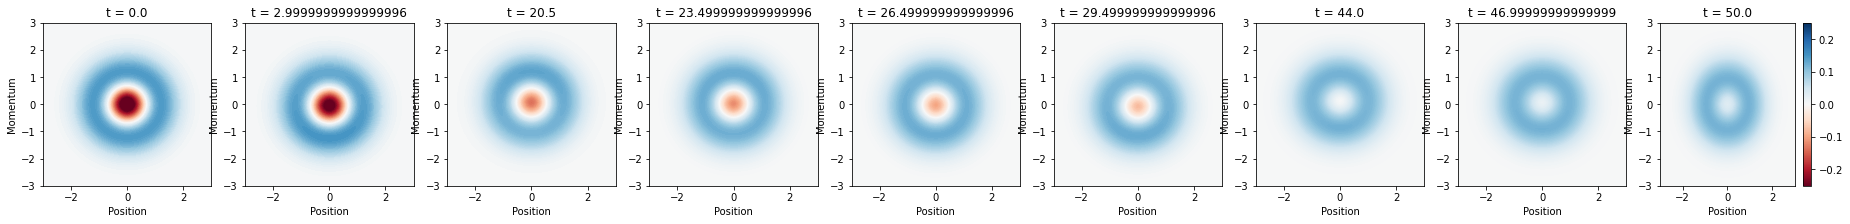

In [15]:
xvec = np.linspace(-3,3,200)
fig, axes = plt.subplots(1,len(dmL), sharex=True, figsize=(3*len(dmL) + 5,3))
cm = plt.get_cmap('RdBu')
sm = plt.cm.ScalarMappable(cmap=cm, norm=mpl.colors.Normalize(-.25,.25))
plt.colorbar(sm)

for idx, dm in enumerate(dmL):
    # get reduced dm for cavity
    dm_cavity = ptrace(Qobj(dm), 0)
    
    # calculate its wigner function
    W = wigner(dm_cavity, xvec, xvec) # yes this is position and momentum - wigner_transform is more specific
    
    # plot its wigner function
    axes[idx].contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=cm)
    axes[idx].set_xlabel("Position") # I think this is right ... not sure, here are the sources
    axes[idx].set_ylabel("Momentum")
    axes[idx].set_title(f"t = {tlist[output_gs_times][idx]*GHz}")

    
    # https://en.wikipedia.org/wiki/Optical_phase_space
    # http://mediatum.ub.tum.de/doc/1463517/1463517.pdf
    # https://uncw.edu/phy/documents/shafer499talk.pdf
    # https://dergipark.org.tr/en/download/article-file/130801

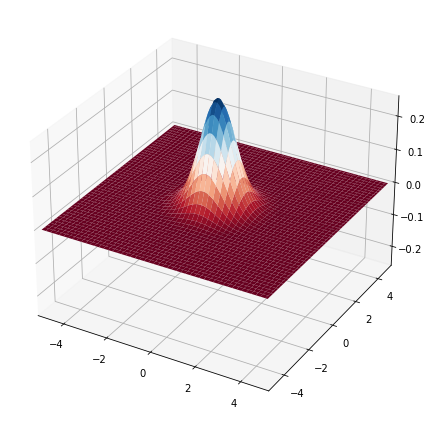

In [16]:
#
# Animation of Wigner Fn
# 
plt.rcParams["figure.figsize"] = [12,6]
plt.rcParams["figure.autolayout"] = True

fps = 20
frn = 75

xvec = np.linspace(-5.,5.,100)
x,y = np.meshgrid(xvec, xvec)

dm_cavity = ptrace(Qobj(output.states[0]), 0) #states[n] initially
W = wigner(dm_cavity, xvec, xvec)    

def update_plot(frame_number):
    plot[0].remove()
    dm_cavity = ptrace(output.states[frame_number], 0)
    W = wigner(dm_cavity, xvec, xvec)
    plot[0] = ax.plot_surface(x,y,W, cmap = plt.get_cmap('RdBu'))
    return plot
    
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
plot = [ax.plot_surface(x, y, W, color='0.75',rstride=1, cstride=1)]


ax.set_xlim3d(-5, 5)
ax.set_ylim3d(-5, 5)
ax.set_zlim3d(-0.25, 0.25)

anim = animation.FuncAnimation(fig, update_plot, frn, interval=1000/fps, blit = False)
#plt.show()
HTML(anim.to_html5_video())


